In [ ]:
from nipype.interfaces.io import DataSink, SelectFiles, DataGrabber, FreeSurferSource # Data i/o
from nipype.interfaces.utility import IdentityInterface, Function     # utility
from nipype.pipeline.engine import Node, Workflow, MapNode, JoinNode        # pypeline engine
from pandas import DataFrame, read_csv
import statsmodels.formula.api as smf

#set output file type for FSL to NIFTI_GZ
from nipype.interfaces.fsl.preprocess import FSLCommand
FSLCommand.set_default_output_type('NIFTI_GZ')

# MATLAB setup - Specify path to current SPM and the MATLAB's default mode
from nipype.interfaces.matlab import MatlabCommand
MatlabCommand.set_default_paths('~/spm12/toolbox')
MatlabCommand.set_default_matlab_cmd("matlab -nodesktop -nosplash")

# Set study variables
study_home = '/Users/SEAlab/Documents/PPM'
hcpproc_dir = study_home + '/Data'
workflow_dir = study_home + '/Workflows'
cov_file = study_home + '/Misc/covariates.csv'
cov_dataframe = read_csv(cov_file,index_col=None)
cov_dataframe = cov_dataframe.sort_values(by='folder')

analysis='postpartum' #Enter preg or postpartum depending on analysis being run
if analysis=='preg':
    output_dir = study_home + '/fMRIproc/longitudinal_preg'
    cov_dataframe = cov_dataframe[cov_dataframe['age']<40]
elif analysis=='postpartum':
    output_dir = study_home + '/fMRIproc/longitudinal_pp'
    cov_dataframe = cov_dataframe[cov_dataframe['age']>40]

# set analysis specs
n_slices = 4
data_type = 'cortical_thickness'

# set model specifications
model = smf.ols
model_formula = 'Y ~ age'
n_terms = 1

proc_cores = 2 # number of cores of processing for the workflows

In [ ]:
## Data handling nodes

# grab data
def pull_data(data_dict,data_label):
    from nipype import config, logging
    config.enable_debug_mode()
    logging.update_logging(config)
    from glob import glob
    
    file_list = sorted(glob(data_dict[data_label]))
    
    return(file_list)

selectfiles = Node(Function(input_names=['data_dict','data_label'],
                            output_names=['file_list'],
                            function=pull_data), name='selectfiles')
selectfiles.inputs.data_label = data_type

if analysis=='preg':
    selectfiles.inputs.data_dict={'cortical_thickness':hcpproc_dir + '/*_Preg*/MNINonLinear/fsaverage_LR32k/*.thickness.32k_fs_LR.dscalar.nii',
                             'functional_connectivity':hcpproc_dir + ''}
elif analysis=='postpartum':
    selectfiles.inputs.data_dict={'cortical_thickness':hcpproc_dir + '/*_PP*/MNINonLinear/fsaverage_LR32k/*.thickness.32k_fs_LR.dscalar.nii',
                             'functional_connectivity':hcpproc_dir + ''}

# sink data
substitutions = []
datasink = Node(DataSink(),name='datasink')
datasink.inputs.base_directory = output_dir
datasink.inputs.container = output_dir
datasink.inputs.substitutions = substitutions

In [ ]:
# create index for cifti file
def create_indexing(file_list,n_slices):
    import nibabel as nib
    import numpy as np
    from sklearn.utils import Bunch

    img1 = nib.load(file_list[0])
    Y1 = img1.get_fdata()
    N = Y1.shape[0]
    M = Y1.shape[1]
    indexes=Bunch()

    index_labels = ['slice{0}'.format(a) for a in range(0,n_slices)]
    width = int(M/n_slices)
    start=0
    end=width
    i=0
    while end<M:
        indexes[index_labels[i]]=slice(start,end)
        start+=width
        end+=width
        i+=1
    if end-width<M:
        indexes[index_labels[i]]=slice(start,M)
    indexes_list = [indexes[x] for x in indexes.keys()]
    return(indexes_list)

# pull data from the same slice for each file
def agg_data(file_list,index):
    import nibabel as nib
    import numpy as np
    from os.path import basename, abspath
    
    data_stack = []
    for file in file_list:
        img = nib.load(file)
        temp = img.get_fdata()
        temp = temp[:,index]
        temp_file = basename(file).replace('.nii','.slice.npy')
        np.save(temp_file,temp)
        data_stack.append(abspath(temp_file))
        
    return(data_stack)

# run models on data
def run_long_models(model,model_formula,data_stack,covariates,n_terms):
    import numpy as np
    from os.path import basename,abspath

    data_list = []
    for d in data_stack:
        t = np.load(d)
        t = np.expand_dims(t,axis=2)
        data_list.append(t)

    sub_data = np.concatenate(data_list, axis=2)

    m = sub_data.shape[0]
    n = sub_data.shape[1]

    p_vals = np.zeros((m,n,n_terms+1))
    t_vals = np.zeros((m,n,n_terms+1))
    beta_vals = np.zeros((m,n,n_terms+1))

    for a in range(0,m):
        for b in range(0,n):
            covariates['Y'] = sub_data[a,b,:]
            mdl = model(formula=model_formula, data=covariates).fit()
            beta_vals[a,b,:] = mdl.params
            p_vals[a,b,:] = mdl.pvalues
            t_vals[a,b,:] = mdl.tvalues

    p_file = 'p_slice.npy'
    t_file = 't_slice.npy'
    beta_file = 'beta_slice.npy'

    np.save(p_file,p_vals)
    np.save(t_file, t_vals)
    np.save(beta_file,beta_vals)

    p_slice = abspath(p_file)
    t_slice = abspath(t_file)
    beta_slice = abspath(beta_file)
    return(p_slice,beta_slice,t_slice)

# reconstitute the results into cifti files
def combine_data(p_list,beta_list,t_list,index_list,n_terms,file_list):
    import nibabel as nib
    import numpy as np
    from os.path import abspath
    
    img = nib.load(file_list[0])
    img_data = img.get_fdata()

    p_data = np.empty((img_data.shape[0],img_data.shape[1],n_terms+1))
    t_data = np.empty((img_data.shape[0],img_data.shape[1],n_terms+1))
    beta_data = np.empty((img_data.shape[0],img_data.shape[1],n_terms+1))
    
    print(index_list)

    for x in range(0,len(index_list)):
        p_data[:,index_list[x],:] = np.load(p_list[x])
        t_data[:,index_list[x],:] = np.load(t_list[x])
        beta_data[:,index_list[x],:] = np.load(beta_list[x])

    # get cifti header info from first file
    bm = img.header.get_axis(1)
    sc = img.header.get_axis(0)
    
    pval_cifti = []
    tstat_cifti = []
    beta_cifti = []
    
    for x in range(0,n_terms+1):
        # p-values
        temp_p = p_data[:,:,x]
        temp_p[temp_p>.05] = 1
        sc.name = ['pvalues']
        p_img = nib.cifti2.cifti2.Cifti2Image(temp_p,(sc,bm))
        nib.save(p_img,'model_pvalues_term{0}.dscalar.nii'.format(x))
        pval_cifti.append(abspath('model_pvalues_term{0}.dscalar.nii'.format(x)))
        # t-values
        temp_t = t_data[:,:,x]
        temp_t[temp_p>.05] = 0
        sc.name = ['tvalues']
        t_img = nib.cifti2.cifti2.Cifti2Image(temp_t,(sc,bm))
        nib.save(t_img,'model_tvalues_term{0}.dscalar.nii'.format(x))
        tstat_cifti.append(abspath('model_tvalues_term{0}.dscalar.nii'.format(x)))
        #beta values
        temp_b = beta_data[:,:,x]
        temp_b[temp_p>.05] = 0
        sc.name = ['beta']
        b_img = nib.cifti2.cifti2.Cifti2Image(temp_b,(sc,bm))
        nib.save(b_img,'model_beta_term{0}.dscalar.nii'.format(x))
        beta_cifti.append(abspath('model_beta_term{0}.dscalar.nii'.format(x)))
    
    return(pval_cifti,beta_cifti,tstat_cifti)


In [ ]:
# Node to wrap the function that makes the list of indexes
make_indexes = Node(Function(input_names=['file_list','n_slices'], output_names=['indexes_list'], 
                             function=create_indexing),name='create_indexing')
make_indexes.inputs.n_slices=n_slices

# Node to wrap the function that pulls the data to model
pull_data = MapNode(Function(input_names=['file_list','index'],output_names=['data_stack'],
                             function=agg_data),name='pull_data', iterfield=['index'])

# Node to wrap the function that runs the longitudinal model
run_models = MapNode(Function(input_names=['model','model_formula','data_stack','covariates','n_terms'],
                              output_names=['p_slice','beta_slice','t_slice'], function=run_long_models),
                     name='run_models',iterfield=['data_stack'])
run_models.inputs.model=model
run_models.inputs.model_formula=model_formula
run_models.inputs.covariates=cov_dataframe
run_models.inputs.n_terms=n_terms

# Node to recombine the data slices for visualization
recombine_data = Node(Function(input_names=['p_list','beta_list','t_list','index_list','n_terms','file_list'],
                               output_names=['pval_cifti','beta_cifti','tstat_cifti'],function=combine_data),
                      name='recombine_data')
recombine_data.inputs.n_terms = n_terms

In [ ]:
long_model = Workflow(name='long_model', base_dir=workflow_dir)
long_model.connect([(selectfiles,make_indexes,[('file_list','file_list')]),
                    (selectfiles,pull_data,[('file_list','file_list')]),
                    (selectfiles,recombine_data,[('file_list','file_list')]),
                    (make_indexes, pull_data, [('indexes_list','index')]),
                    (pull_data, run_models, [('data_stack','data_stack')]),
                    (make_indexes, recombine_data, [('indexes_list','index_list')]),
                    (run_models, recombine_data, [('p_slice','p_list'),
                                                  ('beta_slice','beta_list'),
                                                  ('t_slice','t_list')]),
                    (recombine_data, datasink, [('pval_cifti','pvalues'),
                                                ('beta_cifti','betas'),
                                                ('tstat_cifti','tstats')])
                   ])
long_model.run('MultiProc', plugin_args={'n_procs':proc_cores})

# Pull Parcel-Level Data

In [ ]:
import pandas as pd

# Set study variables
study_home = '/Users/SEAlab/Documents/PPM'
hcpproc_dir = study_home + '/Data'
output_dir = study_home + '/fMRIproc/longitudinal/struct_data'
cov_file = study_home + '/Misc/covariates.csv'
cov_dataframe = pd.read_csv(cov_file,index_col=None)
cov_dataframe = cov_dataframe.sort_values(by='folder')


In [ ]:
def combine_freesurfer_data(subject_list,data_filepath,outfile_name):
    import pandas as pd
    
    
    sub_dfs = []

    if 'aseg.stats' in data_filepath:
        columns = ['Index','SegId','NVoxels','Volume_mm3','StructName','normMean','normStdDev','normMin','normMax','normRange']
        for sub in subject_list:
            file = data_filepath.format(sub)
            df = pd.read_csv(file,index_col='StructName',comment='#',sep='\s+',header=None, names=columns)
            df = df[['Volume_mm3']].transpose()
            df.index=[sub]
            sub_dfs.append(df)

    elif 'aparc' in data_filepath:
        columns = ['StructName','NumVert','SurfArea','GrayVol','ThickAvg','ThickStd','MeanCurv','GausCurv','FoldInd','CurvInd']
        for sub in subject_list:
            file = data_filepath.format(sub)
            df = pd.read_csv(file,index_col='StructName',comment='#',sep='\s+',header=None, names=columns)
            df = df[['SurfArea','GrayVol','ThickAvg']].transpose()
            df['measure'] = df.index
            df.index=[sub,sub,sub]
            sub_dfs.append(df)

    if 'brainvol' in data_filepath:
        columns = ['StructName','Description','Volume_mm3','metric']
        for sub in subject_list:
            file = data_filepath.format(sub)
            df = pd.read_csv(file,index_col=None,header=None, names=columns)
            df.index = df['StructName']
            df = df[['Volume_mm3']].transpose()
            df.index=[sub]
            sub_dfs.append(df)

    full_data = pd.concat(sub_dfs)
    full_data.to_csv('{0}.csv'.format(outfile_name))

In [ ]:
subject_list = cov_dataframe['folder']
stat_list = [hcpproc_dir+'/{0}/T1w/{0}/stats/brainvol.stats',
             hcpproc_dir+'/{0}/T1w/{0}/stats/aseg.stats',
             hcpproc_dir+'/{0}/T1w/{0}/stats/lh.aparc.DKTatlas.stats',
             hcpproc_dir+'/{0}/T1w/{0}/stats/rh.aparc.DKTatlas.stats',]
outnames = [output_dir+'/brain_volumes',
            output_dir+'/segmentation',
            output_dir+'/left_DKTparc',
            output_dir+'/right_DKTparc']

for i, stat in enumerate(stat_list):
    combine_freesurfer_data(subject_list,stat,outnames[i])

# Connectivity Analysis

In [1]:
import nibabel as nib
import numpy as np
data_dir = '/Users/SEAlab/Documents/PPM/Data'

from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler((8000,10000))
late_preg_data=[]
for v in ["Preg4","Preg5"]:
    temp=nib.load(data_dir+'/1196_late_preg/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).get_fdata()
    Ax1=nib.load(data_dir+'/1196_late_preg/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(0)
    Ax2=nib.load(data_dir+'/1196_late_preg/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(1)
    temp=mm.fit_transform(temp)
    late_preg_data.append(temp)

concatenate_data=np.concatenate(late_preg_data)
nvol=concatenate_data.shape[0]
Ax1.size=nvol

late_preg_image=nib.cifti2.cifti2.Cifti2Image(concatenate_data,(Ax1,Ax2))
nib.save(late_preg_image, data_dir+'/1196_late_preg/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.ptseries.nii')

#from sklearn.preprocessing import MinMaxScaler
#mm=MinMaxScaler((8000,10000))
#early_preg_data=[]
#for v in ["Preg1","Preg2s"]:
    #temp=nib.load(data_dir+'/1196_early_preg/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).get_fdata()
    #Ax1=nib.load(data_dir+'/1196_early_preg/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(0)
    #Ax2=nib.load(data_dir+'/1196_early_preg/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(1)
    #temp=mm.fit_transform(temp)
    #early_preg_data.append(temp)

#concatenate_data=np.concatenate(early_preg_data)
#nvol=concatenate_data.shape[0]
#Ax1.size=nvol

#early_preg_image=nib.cifti2.cifti2.Cifti2Image(concatenate_data,(Ax1,Ax2))
#nib.save(early_preg_image, data_dir+'/1196_early_preg/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.ptseries.nii')

#from sklearn.preprocessing import MinMaxScaler
#mm=MinMaxScaler((8000,10000))
#early_PP_data=[]
#for v in ["PP1","PP2"]:
    #temp=nib.load(data_dir+'/1196_early_PP/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).get_fdata()
    #Ax1=nib.load(data_dir+'/1196_early_PP/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(0)
    #Ax2=nib.load(data_dir+'/1196_early_PP/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(1)
    #temp=mm.fit_transform(temp)
    #early_PP_data.append(temp)

#concatenate_data=np.concatenate(early_PP_data)
#nvol=concatenate_data.shape[0]
#Ax1.size=nvol

#early_PP_image=nib.cifti2.cifti2.Cifti2Image(concatenate_data,(Ax1,Ax2))
#nib.save(early_PP_image, data_dir+'/1196_early_PP/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.ptseries.nii')

from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler((8000,10000))
late_PP_data=[]
for v in ["PP3","PP4"]:
    temp=nib.load(data_dir+'/1196_late_PP/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).get_fdata()
    Ax1=nib.load(data_dir+'/1196_late_PP/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(0)
    Ax2=nib.load(data_dir+'/1196_late_PP/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(1)
    temp=mm.fit_transform(temp)
    late_PP_data.append(temp)

concatenate_data=np.concatenate(late_PP_data)
nvol=concatenate_data.shape[0]
Ax1.size=nvol

late_PP_image=nib.cifti2.cifti2.Cifti2Image(concatenate_data,(Ax1,Ax2))
nib.save(late_PP_image, data_dir+'/1196_late_PP/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.ptseries.nii')

In [7]:
from sklearn.preprocessing import MinMaxScaler
mm=MinMaxScaler((8000,10000))
all_timepoints_data=[]
for v in ["Preg1","Preg2s","Preg4","Preg5","PP1","PP2","PP3","PP4"]:
    temp=nib.load(data_dir+'/1196_All_Timepoints/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).get_fdata()
    Ax1=nib.load(data_dir+'/1196_All_Timepoints/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(0)
    Ax2=nib.load(data_dir+'/1196_All_Timepoints/{0}_rest_Atlas.GORDparcel.32k_fs_LR.ptseries.nii'.format(v)).header.get_axis(1)
    temp=mm.fit_transform(temp)
    all_timepoints_data.append(temp)

concatenate_data=np.concatenate(all_timepoints_data)
nvol=concatenate_data.shape[0]
Ax1.size=nvol

all_timepoints_image=nib.cifti2.cifti2.Cifti2Image(concatenate_data,(Ax1,Ax2))
nib.save(all_timepoints_image, data_dir+'/1196_All_Timepoints/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.ptseries.nii')

In [10]:
import nibabel as nib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

study_home = '/Users/SEAlab/Documents/PPM'
data_dir = '/Users/SEAlab/Documents/PPM/Data'
output_dir = study_home + '/fMRIproc/longitudinal/fmri_data'

#early_preg_image = nib.load(data_dir+'/1196_early_preg/MERGED_rest_Atlas.CABparcel.32k_fs_LR.pconn.nii')
#early_preg_data = nib.load(data_dir+'/1196_early_preg/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.pconn.nii').get_fdata()
#late_preg_data = nib.load(data_dir+'/1196_late_preg/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.pconn.nii').get_fdata()
#early_PP_data = nib.load(data_dir+'/1196_early_PP/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.pconn.nii').get_fdata()
#late_PP_data = nib.load(data_dir+'/1196_late_PP/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.pconn.nii').get_fdata()
all_timepoints_data = nib.load(data_dir+'/1196_All_Timepoints/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.pconn.nii').get_fdata()
#combined_data = np.concatenate([np.expand_dims(late_preg_data, axis=2),
                               #np.expand_dims(early_PP_data, axis=2),
                                #np.expand_dims(late_PP_data, axis=2)], axis=2)

early_preg_image = nib.load(data_dir+'/1196_early_preg/MERGED_rest_Atlas_rescaled.GORDparcel.32k_fs_LR.pconn.nii')
Ax1=early_preg_image.header.get_axis(0)
#early_preg_df=pd.DataFrame(early_preg_data,index=Ax1.name,columns=Ax1.name)
#late_preg_df=pd.DataFrame(late_preg_data,index=Ax1.name,columns=Ax1.name)
#early_PP_df=pd.DataFrame(early_PP_data,index=Ax1.name,columns=Ax1.name)
#late_PP_df=pd.DataFrame(late_PP_data,index=Ax1.name,columns=Ax1.name)
all_timepoints_df=pd.DataFrame(all_timepoints_data,index=Ax1.name,columns=Ax1.name)

#PP_preg_diff=early_PP_df-late_preg_df
#preg_diff=late_preg_df-early_preg_df
#PP_diff=late_PP_df-early_PP_df

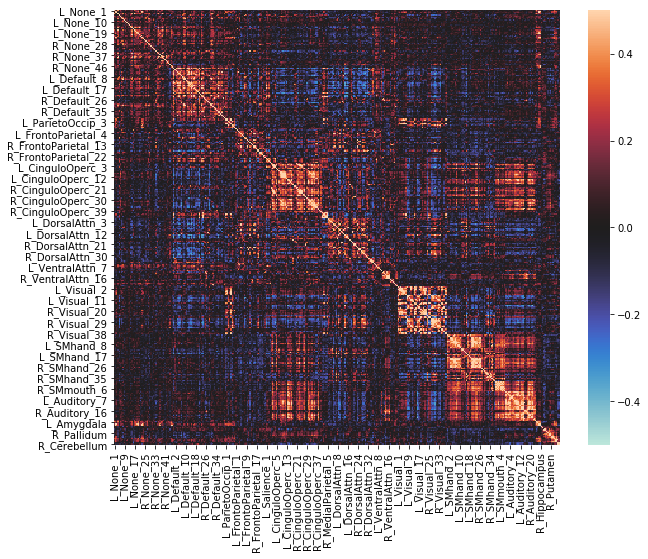

In [11]:
#sns.set(context="talk",style="white")

#plt.figure(figsize=(10,8))
#sns.heatmap(early_preg_df,center=0, vmin=-0.5, vmax=0.5)
#plt.savefig("early_preg_conn.svg")

plt.figure(figsize=(10,8))
sns.heatmap(all_timepoints_df,center=0, vmin=-0.5, vmax=0.5)

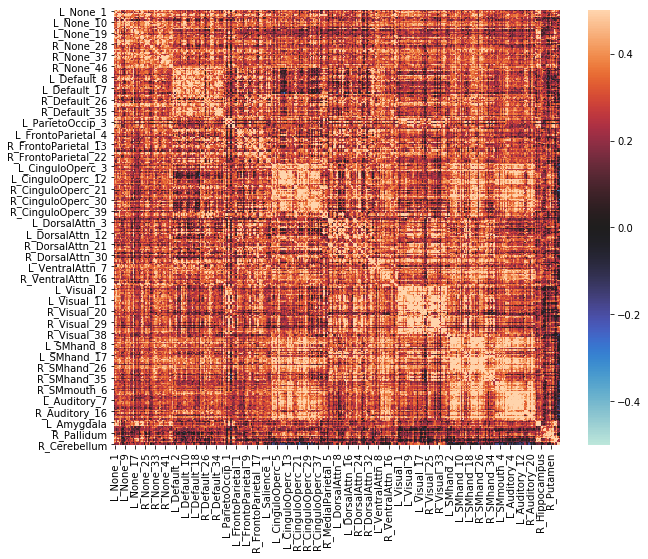

In [5]:
plt.figure(figsize=(10,8))
sns.heatmap(late_preg_df,center=0, vmin=-0.5, vmax=0.5)

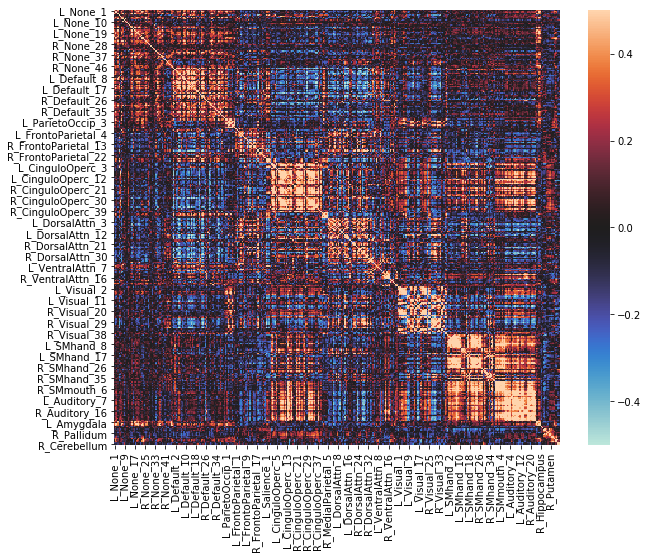

In [6]:
plt.figure(figsize=(10,8))
sns.heatmap(early_PP_df,center=0, vmin=-0.5, vmax=0.5)

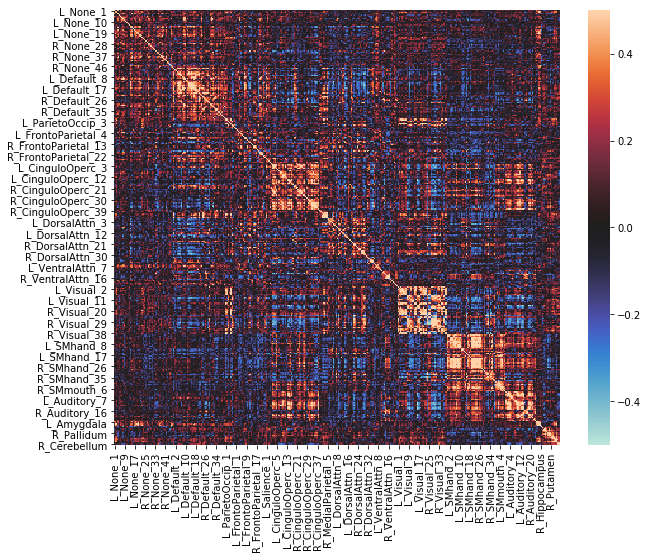

In [7]:
plt.figure(figsize=(10,8))
sns.heatmap(late_PP_df,center=0, vmin=-0.5, vmax=0.5)

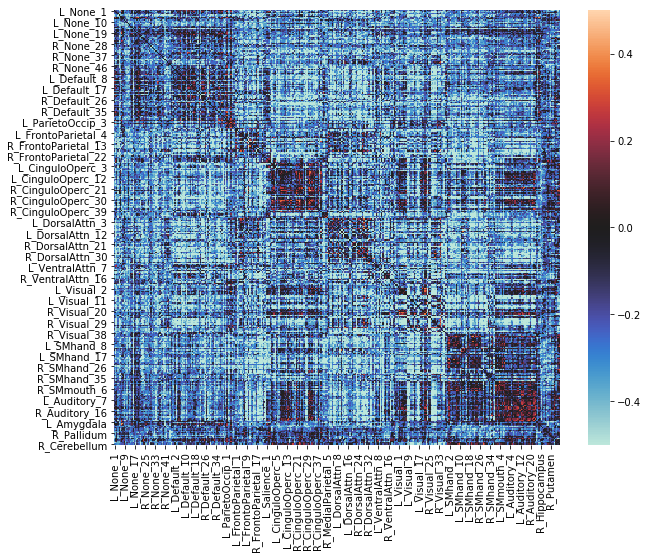

In [8]:
plt.figure(figsize=(10,8))
sns.heatmap(PP_preg_diff,center=0, vmin=-0.5, vmax=0.5)

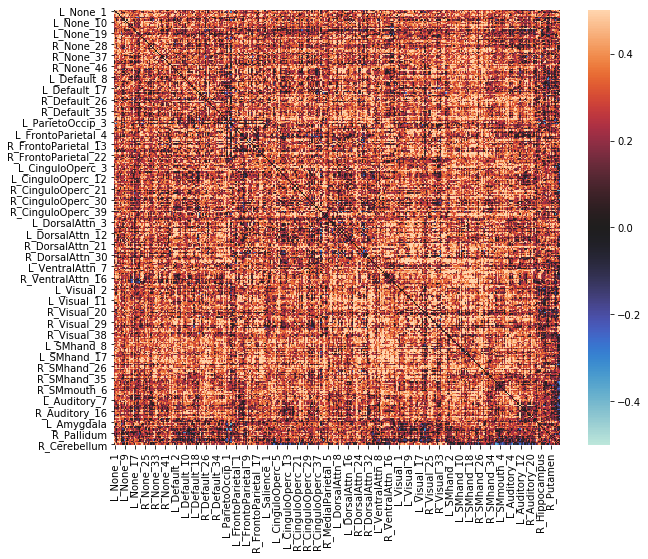

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(preg_diff,center=0, vmin=-0.5, vmax=0.5)

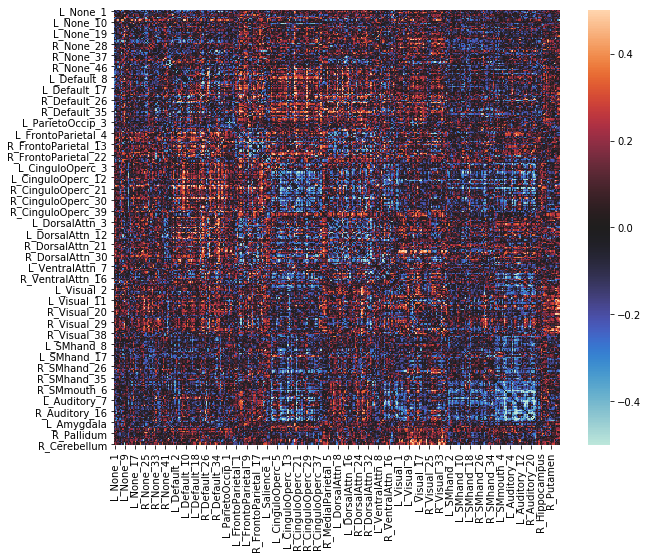

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(PP_diff,center=0, vmin=-0.5, vmax=0.5)

In [ ]:
fig,ax=plt.subplots(1)
ax.plot(combined_data[0,1,:])
ax.set_ylabel("pearson R")
ax.set_xticks(["Late_Preg","Early_PP","Late_PP"])

In [ ]:
ts_data=nib.load(data_dir+"/1196_early_preg/Preg1_rest_Atlas.CABparcel.32k_fs_LR.ptseries.nii").get_fdata()
plt.plot(ts_data[:,2])